
A text summarizer based on Attention mechanism

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

### Import required library
The cell below import required library, we will be using torchtext for preprocessing as it does all the prossing for us. 

Importing data from Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data = pd.read_csv(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/news_summary_more.csv')
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [10]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data[(data['headlines'].apply(len) == 0) | (data['headlines'].apply(len) == 0)]

,headlines,text


Splitting data into training, validation and testing set

In [11]:
train_X, other_X, train_y, other_y = train_test_split(data['text'], data['headlines'], test_size=0.2, shuffle=True)
val_X, test_X, val_y, test_y = train_test_split(data['text'], data['headlines'], test_size=0.5, shuffle=True)
print(f"""
Shape of train data : {train_X.shape}
Shape of val data : {val_X.shape}
Shape of test data : {test_X.shape}
""")


Shape of train data : (78703,)
Shape of val data : (49189,)
Shape of test data : (49190,)



Saving the splitted data into CSV's for easy reuse:

In [12]:
pd.concat([train_X,train_y],axis=1).to_csv(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/data/train.csv.csv', header=False, index=False)
pd.concat([val_X,val_y],axis=1).to_csv(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/data/val.csv', header=False, index=False)
pd.concat([test_X,test_y],axis=1).to_csv(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/data/test.csv', header=False, index=False)

In [13]:
#checking training set
pd.concat([train_X,train_y],axis=1)

,text,headlines
79440,University of Mumbai (MU) hopes to declare the...,Mumbai University results to be out by August ...
4167,Former Uttar Pradesh CM Akhilesh Yadav on Sund...,Ghazipur stone-pelting 'failure of administrat...
64116,There is growing evidence that people who eat ...,Low intake of fruits & veggies can make you fe...
28910,Reminding the fans to support the Indian women...,Feeling the void after IPL? We're playing Asia...
77017,The Delhi Pradesh Congress Committee organised...,Delhi Congress protests against attack on Rahu...
...,...,...
60228,The BCCI has changed the start timings of the ...,Start time of first 2 ODIs vs SL changed owing...
50595,India beat Bangladesh by 131 runs to remain un...,"India reach U-19 World Cup semi-finals, will f..."
5291,The Bombay High Court has dismissed a petition...,Activist's plea to quash FIR in Bhima-Koregaon...
94871,Asserting that Buddhists were neither vegetari...,"Fine to eat dead animals, not those slaughtere..."


MODEL:

In [14]:
#import required libraries
import math
import dill

import spacy
import seaborn as sns
import matplotlib.ticker as ticker

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator, TabularDataset

import time
import random

from helper import *

#setting device to cuda if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Torchtext Field
Initializing fields for our source and target feature using:
1. spacy tokenizer for word tokenization. 
2. definining start and end of string token `<sos>` & `<eos>` respectively. 
3. packing of inputs.

In [15]:
ARTICLE = Field(tokenize='spacy',
                init_token='<sos>',
                eos_token='<eos>',
                lower=True,
                include_lengths=True
                )
SUMMARY = Field(tokenize='spacy',
                init_token='<sos>',
                eos_token='<eos>',
                lower=True,
                )

### Loading the dataset
Using TabularDataset for loading train, test and validation dataset.

In [16]:
#load train, test, val data
train_data, valid_data, test_data = TabularDataset.splits(
                                                    path=r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/data/',
                                                    train='train.csv',
                                                    validation='val.csv',
                                                    test='test.csv', 
                                                    format='csv',
                                                    fields=[("text",ARTICLE),('headline',SUMMARY)]
                                                        )

In [17]:
#setting up vocabulary for the article and summary from training data.
ARTICLE.build_vocab(train_data, min_freq=2)
SUMMARY.build_vocab(train_data, min_freq=2)

### Checkpoint I
Saving article and summary Field for further use.

In [18]:
#Saving the article and summary field into Article and Summary files for easy loading
with open(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/brain/ARTICLE.Field',"wb")as f:
     dill.dump(ARTICLE,f)
with open(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/brain/SUMMARY.Field',"wb")as f:
     dill.dump(SUMMARY,f)

### DataIterator
Setting dataloaders using BucketIterator as it groups data such that minimum padding is required.

In [19]:
#Creating training, validation, and testing loaders
BATCH_SIZE = 128

train_loader, valid_loader, test_loader = BucketIterator.splits(
                                                            (train_data, valid_data, test_data),
                                                            batch_size=BATCH_SIZE,
                                                            sort_within_batch=True,
                                                            sort_key = lambda x:len(x.text),
                                                            device=device
                                                                )

## Model
Creating encoder decoder based seq2seq model with Attention. 
1. The input to the model is a seqeunce of text ie. Article, and it passes it through encoder to produce a list of hidden states in each time step. 
2. The list of all the hidden states will be input to the decoder along with token `<sos>`.
3. The attention mechanism will take the current decoder hidden state along with a list of encoder hidden states and calculates attention score while creating context vector based on the score.
4. The context vector generated and the ouput of decoder gru will be concatenated and passed to a fully contected feed forward layer to generate the ouput.
5. The steps 2, 3, 4 will be repeated until either maximum length set is reached or `<eos>` is predicted.

### Encoder
Passing seqeunce of string to bidirectional GRU to encode it into vectors.

In [20]:
#Encoder class, encodes article to vector

class Encoder(nn.Module):
    
    
    def __init__(self, vocab, embeding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab, embeding_dim)
        self.gru = nn.GRU(embeding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim*2, decoder_hidden_dim)
        
        self.dropout = nn.Dropout(p=dropout)
   

    def forward(self, text, text_len):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_len.cpu())
        packed_outputs, hidden = self.gru(packed_embedded) 
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

### Attention Mechanism
Takes encoder hidden layer and decoder hidden layer as input, scores it and return context vector as the output.

In [21]:
# Attention machanism to take encoder hidden states and current decoder state and generate context vector
class Attention(nn.Module):
    
    
    def __init__(self, enc_hid_dim, dec_hid_dim ):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    

    def forward(self, hidden, encoder_outputs, mask):      
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        attention = self.v(energy).squeeze(2)
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder
Decoder takes all the encoder hidden states and (t-1) input and predicts the next word in the sequence as output using attention mechanism.

In [22]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)        
        self.gru = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)        
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_, hidden, encoder_outputs, mask):
    
        input_ = input_.unsqueeze(0)
        embedded = self.dropout(self.embedding(input_))

        atten = self.attention(hidden, encoder_outputs, mask)        
        atten = atten.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(atten, encoder_outputs)
        
        weighted = weighted.permute(1, 0, 2)        
        gru_input_ = torch.cat((embedded, weighted), dim = 2)
            
        output, hidden = self.gru(gru_input_, hidden.unsqueeze(0))
              
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0), atten.squeeze(1)

### Seq2Seq Model
Encapsulating Encoder Decor model.

In [23]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, text_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.text_pad_idx = text_pad_idx
        self.device = device
        
    def create_mask(self, text):
        mask = (text != self.text_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, text, text_len, headline, teacher_forcing_ratio = 0.5):
        batch_size = text.shape[1]
        headline_length = headline.shape[0]
        headline_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(headline_length, batch_size, headline_vocab_size).to(self.device)
      
        encoder_outputs, hidden = self.encoder(text, text_len)
       
        input_ = headline[0,:]
        
        mask = self.create_mask(text)
                
        for t in range(1, headline_length):
            
            output, hidden, _ = self.decoder(input_, hidden, encoder_outputs, mask)           
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio            
            top_first = output.argmax(1)             
            input_ = headline[t] if teacher_force else top_first
            
        return outputs

Loading saved article and summary fields. 

In [24]:
#only run in case of new or kernal restart

with open(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/brain/ARTICLE.Field',"rb")as f:
     ARTICLE=dill.load(f)
with open(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/brain/SUMMARY.Field',"rb")as f:
     SUMMARY=dill.load(f)

### Model Initialization 
Initializing model with parameters 

In [25]:
# model parameters, dimension kept less due to memory issue.

INPUT_DIM = len(ARTICLE.vocab)
OUTPUT_DIM = len(SUMMARY.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
ARTICLE_PAD_IDX = ARTICLE.vocab.stoi[ARTICLE.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, ARTICLE_PAD_IDX, device).to(device)

In [26]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(50618, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(21438, 256)
    (gru): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=21438, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


###  Optimizer and Cost Function

In [27]:
#setting up optimizer for training model

optimizer = optim.Adam(model.parameters())

In [28]:
#setting up loss function and ignoring pad index

SUMMARY_PAD_IDX = SUMMARY.vocab.stoi[SUMMARY.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = SUMMARY_PAD_IDX)

#### Training and Evalution functions

In [29]:
import matplotlib
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [30]:
#function to train model
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    plot_losses = []
    plot_loss_total = 0  # Reset every plot_every

    
    for i, batch in enumerate(iterator):
        
        text, text_len = batch.text
        headline = batch.headline
        optimizer.zero_grad()
        output = model(text, text_len, headline)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        headline = headline[1:].view(-1)
        loss = criterion(output, headline)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        # if i % 1000 == 0:
        #     plot_loss_avg = epoch_loss / 100
        #     plot_losses.append(plot_loss_avg)
        #     plot_loss_total = 0
        
    return epoch_loss / len(iterator)

In [31]:
#function to return validation loss
def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            text, text_len = batch.text
            headline = batch.headline
            output = model(text, text_len, headline, 0) #turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            headline = headline[1:].view(-1)
            loss = criterion(output, headline)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#### Training Model
Model trainig and saving the best fitted model

In [32]:
# trainig model

N_EPOCHS = 24
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/model.brain')
    
    print(f'Epoch: {epoch+1:2}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch:  1
	Train Loss: 6.290 | Train PPL: 539.045
	 Val. Loss: 5.226 |  Val. PPL: 185.989
Epoch:  2
	Train Loss: 4.924 | Train PPL: 137.570
	 Val. Loss: 4.401 |  Val. PPL:  81.508
Epoch:  3
	Train Loss: 4.231 | Train PPL:  68.802
	 Val. Loss: 4.014 |  Val. PPL:  55.389
Epoch:  4
	Train Loss: 3.762 | Train PPL:  43.041
	 Val. Loss: 3.835 |  Val. PPL:  46.289
Epoch:  5
	Train Loss: 3.461 | Train PPL:  31.834
	 Val. Loss: 3.705 |  Val. PPL:  40.648
Epoch:  6
	Train Loss: 3.258 | Train PPL:  25.988
	 Val. Loss: 3.646 |  Val. PPL:  38.327
Epoch:  7
	Train Loss: 3.113 | Train PPL:  22.483
	 Val. Loss: 3.574 |  Val. PPL:  35.641
Epoch:  8
	Train Loss: 3.003 | Train PPL:  20.143
	 Val. Loss: 3.534 |  Val. PPL:  34.258
Epoch:  9
	Train Loss: 2.883 | Train PPL:  17.872
	 Val. Loss: 3.490 |  Val. PPL:  32.784
Epoch: 10
	Train Loss: 2.819 | Train PPL:  16.762
	 Val. Loss: 3.458 |  Val. PPL:  31.769
Epoch: 11
	Train Loss: 2.745 | Train PPL:  15.570
	 Val. Loss: 3.419 |  Val. PPL:  30.536
Epoch: 12


#### Load best fitted model

In [34]:
#load best fitted model and calculating test loss
model.load_state_dict(torch.load(r'/content/drive/MyDrive/ColabNotebooks/BigDataProject/compendium-master/application/model/model.brain', map_location=device))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.265 | Test PPL:  26.191 |


## Prediction
Predicting  summary along with its attention matrix

In [38]:
#function to dengerate summary from saved model
def predict(sentence, source_field, target_field, model, device, max_len = 50):

    model.eval()
        
    if sentence is str:
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [source_field.init_token] + tokens + [source_field.eos_token]        
    source_indexes = [source_field.vocab.stoi[token] for token in tokens]
    
    source_tensor = torch.LongTensor(source_indexes).unsqueeze(1).to(device)
    source_len = torch.LongTensor([len(source_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(source_tensor, source_len)

    mask = model.create_mask(source_tensor)        
    trg_indexes = [target_field.vocab.stoi[target_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(source_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention            
        pred_token = output.argmax(1).item()        
        trg_indexes.append(pred_token)

        if pred_token == target_field.vocab.stoi[target_field.eos_token]:
            break
    
    target_tokens = [target_field.vocab.itos[i] for i in trg_indexes]
    
    return target_tokens[1:], attentions[:len(target_tokens)-1]

In [36]:
# function to plot attention scores
from matplotlib import pyplot as plt

def plot_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(30,30))
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = sns.heatmap(attention,cmap='gray', cbar=False, square=True,\
                     yticklabels=translation,xticklabels=sentence) 
    cax.set_yticklabels(cax.get_yticklabels(), rotation = 0, fontsize = 20)
    cax.set_xticklabels(cax.get_xticklabels(), rotation = 90, fontsize = 20)


####  Prdiction for random index

Text = whatsapp on wednesday announced that it is rolling out a radio campaign across india to fight fake news . the campaign will air on 46 hindi speaking stations of all india radio , across bihar , jharkhand , rajasthan , uttarakhand , chhattisgarh , and others . earlier , the facebook - owned company had also released full - page advertisements in newspapers listing tips to tackle fake news .

Headline = whatsapp launches radio campaign in india to fight fake news

Predicted Headline = whatsapp launches radio campaign radio campaign fight fight fake news <eos>

							Attention Plot


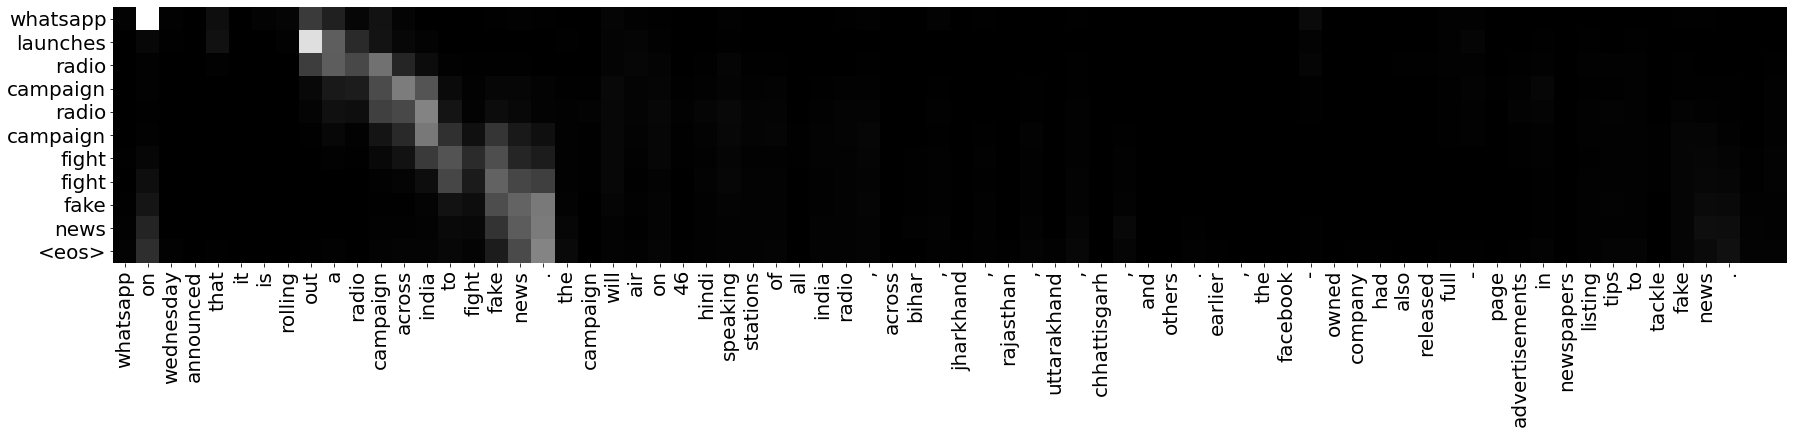

In [39]:
#testing
example_index = 60

bold_start, bold_end = "\033[1m", "\033[0;0m"
text = vars(test_data.examples[example_index])['text']
headline = vars(test_data.examples[example_index])['headline']

print(f'{bold_start}Text{bold_end} = {" ".join(word for word in text)}\n')
print(f'{bold_start}Headline{bold_end} = {" ".join(word for word in headline)}\n')

prediction, attention = predict(text, ARTICLE, SUMMARY, model, device)

print(f'{bold_start}Predicted Headline{bold_end} = {" ".join(word for word in prediction)}')
print("\n\t\t\t\t\t\t\tAttention Plot")
plot_attention(text, prediction, attention)

Text = in a first , germany - based scientists have trapped a particle - based microlaser inside an optical cable . the team launched a laser into a hollow - core fibre containing a microparticle , which produced lasers by itself when excited by a second laser . the new laser could deliver precisely positioned light in a patient 's body for use with light - activated drugs , said a researcher .

Headline = particle - based laser trapped in optical fibre for first time

Predicted Headline = particle particle trapped laser trapped laser - laser trapped <eos>

							Attention Plot


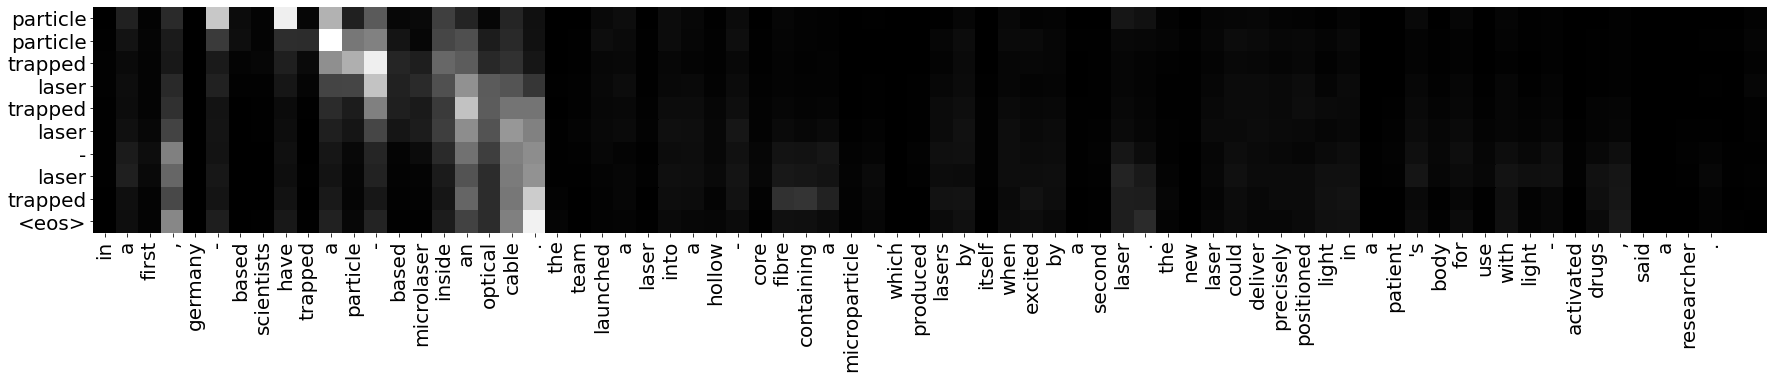

In [40]:
example_index = 1

bold_start, bold_end = "\033[1m", "\033[0;0m"
text = vars(test_data.examples[example_index])['text']
headline = vars(test_data.examples[example_index])['headline']

print(f'{bold_start}Text{bold_end} = {" ".join(word for word in text)}\n')
print(f'{bold_start}Headline{bold_end} = {" ".join(word for word in headline)}\n')

prediction, attention = predict(text, ARTICLE, SUMMARY, model, device)

print(f'{bold_start}Predicted Headline{bold_end} = {" ".join(word for word in prediction)}')
print("\n\t\t\t\t\t\t\tAttention Plot")
plot_attention(text, prediction, attention)